In [7]:
from tools.env_root import root
from datetime import datetime
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import select, BinaryExpression, func

from src.const import BASE_DATA_PATH
from src.db.db_mgmt import DatabaseConfig, DatabaseManager
from src.db.db_models import DBPost, DBCollectionTask

conf = DatabaseConfig("sqlite", (BASE_DATA_PATH / "youtube.sqlite").as_posix())
root(".")
db = DatabaseManager(conf)


# todo use misc.helper
def get_posts(platform: str,
              conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
              ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(
            func.date(DBPost.date_created).label('day'),
            func.count().label('count')
        ).group_by(
            func.date(DBPost.date_created)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        result = session.execute(query)
        return result.all()


2024-12-10 16:08:31,391 - src.db.db_mgmt - DEBUG - creating db engine with sqlite:////home/rsoleyma/projects/platforms-clients/data/youtube.sqlite


In [8]:
def get_year_counts(year: int) -> pd.Series:
    results = get_posts("youtube",
                        conditions=DBPost.date_created.between(
                            datetime(year, 1, 1),
                            datetime(year + 1, 1, 1)
                        ))

    # Convert to pandas Series with days as index
    counts = pd.Series({row[0]: row[1] for row in results})
    return counts

#get_year_counts(2022)

In [32]:
import matplotlib.dates as mdates

def plot_daily_items(daily_counts: pd.Series):
    plt.figure(figsize=(12, 6))

    # Convert index to datetime if not already
    if not isinstance(daily_counts.index, pd.DatetimeIndex):
        daily_counts.index = pd.to_datetime(daily_counts.index)

    # Filter out future dates
    today = pd.Timestamp.now().normalize()
    daily_counts = daily_counts[daily_counts.index <= today]

    # Fill missing dates with 0 only up to today
    date_range = pd.date_range(start=daily_counts.index.min(),
                             end=daily_counts.index.max())
    daily_counts = daily_counts.reindex(date_range, fill_value=0)

    # Create mask for non-zero values
    non_zero = daily_counts[daily_counts > 0]

    # Connect only consecutive days with data
    mask = non_zero.index.to_series().diff() == pd.Timedelta('1 day')
    plt.plot(non_zero[mask].index, non_zero[mask].values, color='blue')

    # Plot zero values with red dots
    zero_days = daily_counts[daily_counts == 0]
    if not zero_days.empty:
        plt.scatter(zero_days.index, zero_days.values,
                   color='red', s=10, label='No Posts',
                   zorder=5)

    plt.title('Daily Post Count (Red Dots = No Posts)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    return plt

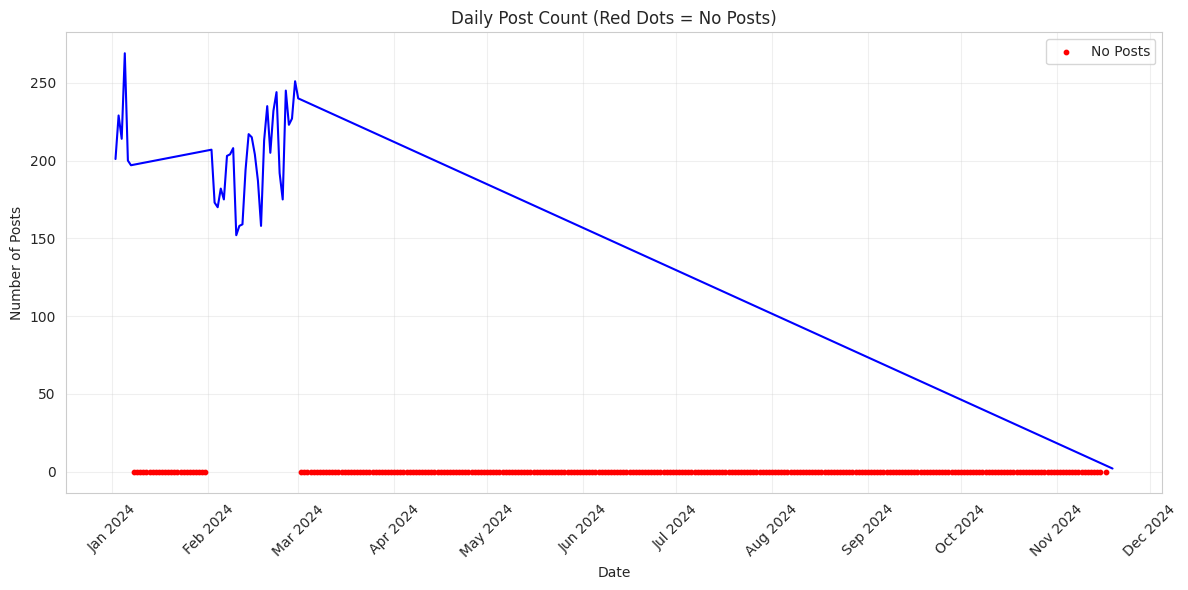

In [33]:

def vis_year(year: int):
    yc = get_year_counts(year)
    plot = plot_daily_items(yc)
    plot.show()
# yc_2023 = get_year_counts(2023)
# plot = plot_daily_items(yc_2023)
# plot.show()


vis_year(2024)

In [8]:
from sqlalchemy.orm import contains_eager


# todo use misc.helper
def get_posts_w_task(platform: str,
                     conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
                     ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost, DBCollectionTask).join(
            DBCollectionTask,
            DBPost.collection_task_id == DBCollectionTask.id
        ).options(
            contains_eager(DBPost.collection_task)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        res = session.execute(query).all()
        return [(post.model(),post_col_task.model()) for post, post_col_task in res]

jan_2022 = get_posts_w_task("youtube", conditions=DBPost.date_created.between(
    datetime(2022, 1, 1),
    datetime(2022, 2, 1)
))

In [16]:
# for post, post_col in jan_2022:
#     print(post_col.collection_config)

len(jan_2022), len([_ for _, post_col in jan_2022 if post_col.collection_config.get("location")])

(3327, 2616)